# Training workflow

In [2]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn
import os
import copy

from IPython.display import Video

## Constants

In [4]:
PREDICTIONS_DIR = "training_set/predictions"

In [5]:
CUDA = torch.cuda.is_available()
RANDOM_SEED = 1
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_EPOCHS = 15

print(f"CUDA: {CUDA}")

CUDA: True


In [6]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Load Data

Extracted features, scores, metadata, etc.

In [7]:
data = pd.read_csv("training_set/scores_v2.csv").set_index("video_id")

In [8]:
from features.video import load_C3D_features
from features.image import load_ResNet152_features, load_LBP_features, load_HOG_features
from features.audio import load_VGGish_features
from features.emotion import load_Emotion_features, extract_emotions

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
data["emotion"] = load_Emotion_features(data.index)

In [ ]:
data["lbp"] = load_LBP_features(data.index)

In [ ]:
data["hog"] = load_HOG_features(data.index)

In [ ]:
data["c3d"] = load_C3D_features(data.index)

In [9]:
data["resnet152"] = load_ResNet152_features(data.index)

In [ ]:
data["vggish"] = load_VGGish_features(data.index)

## Target Prep

Khosla points out that the memorability score used in Isola's paper did not take into account the memory retention duration.
Cohendet utilized the same idea as Khosla, which involved a decay rate

$$\alpha \leftarrow 
\frac{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1} \log(\frac{t^{(i)}_j}{T})[x^{(i)}_j - m^{(i)}_T] }
{\sum^N_{i=1}\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[ \log(\frac{t^{(i)}_j}{T})]^2}
$$

to calculate memorability 
$$
m_T^{(i)} \leftarrow
\frac{1}{n^{(i)}} \sum^{n^{(i)}}_{j=1}[x^{(i)}_j - \alpha \log(\frac{t_j^{(i)}}{T})]
$$

where we have $n^{(i)}$ observations for image $i$ given by $x^{(i)} \in {0,1}$ and $t^{(i)}_j$ where $x_j=1$  implies that the image repeat was correctly detected when it shown after time $t_j$

IDEA: potentially explore calculating $\alpha$ per user

In [10]:
from target_augmentation import add_position_delta, calculate_alpha_and_memorability

In [11]:
annotations = pd.read_csv("training_set/short_term_annotations_v2.csv")

Average t: 74.96191840735993
Calculating adjusted value for m_75
Alpha: -0.026433626378523905


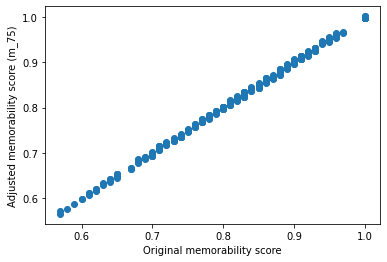

In [12]:
add_position_delta(annotations)

print("Average t:", np.mean(annotations["t"]))

# We use approximately the average_t to calculate T as the memorability in question
big_t = int(np.around(np.mean(annotations["t"])))
label = f"m_{big_t}"
print(f"Calculating adjusted value for {label}")
alpha, data[label] = calculate_alpha_and_memorability(annotations, T = big_t)
print(f"Alpha: {alpha}")
plt.scatter(data["part_1_scores"], data[f"m_{big_t}"])
plt.xlabel("Original memorability score")
plt.ylabel(f"Adjusted memorability score ({label})")
plt.show()

## Data Prep

Building datasets

potentially weighting samples based on annotations?



In [13]:
from train import split_training, build_matrixes

In [14]:
train_data, valid_data = split_training(data)
print("training:",len(train_data))
print("validation:", len(valid_data))

training: 472
validation: 118


#### Pick Features and Target

In [15]:
target = "m_75"
features = "resnet152"

In [16]:
features_train, targets_train, video_ids_train = build_matrixes(train_data, target_name = target, feature_name = features)
features_valid, targets_valid, video_ids_valid = build_matrixes(valid_data, target_name = target, feature_name = features)

print("features_train shape:", features_train.shape)
print("targets_train shape:", targets_train.shape)
print("features_valid shape:", features_valid.shape)
print("features_valid shape:", targets_valid.shape)
total_features = len(features_train) + len(features_valid)
unique, count = np.unique(np.concatenate([video_ids_valid, video_ids_train]), return_counts=True)
print("Total features:", total_features)
print("Total videos:", len(unique))
print("Avg features per video:", total_features / len(unique))
print("Min features per video:", min(count))
print("Max features per video:", max(count))

features_train shape: (3776, 2048)
targets_train shape: (3776, 1)
features_valid shape: (944, 2048)
features_valid shape: (944, 1)
Total features: 4720
Total videos: 590
Avg features per video: 8.0
Min features per video: 8
Max features per video: 8


## Model training

In [17]:
from train import train_two_layer_nn, train_svr

def train_model(model_type, features_train, targets_train, features_valid, targets_valid):
    if "two_layer_nn" == model_type:
        model, train_losses, valid_losses = train_two_layer_nn(
            features_train, targets_train, features_valid, targets_valid,
            hidden_dim = 100,
            num_epochs=NUM_EPOCHS,
            cuda=CUDA,
            batch_size=BATCH_SIZE,
            learning_rate=LEARNING_RATE
        )

        plt.plot(train_losses, label="Training Loss")
        plt.plot(valid_losses, label="Validation Loss")
        plt.legend()
        plt.show()

    elif "svr" == model_type:
        model = train_svr(features_train, targets_train)
    else:
        raise ValueError(f"'{model_type}' is not a valid model type")
    return model
        

In [18]:
model_type = "svr"

model = train_model(model_type, features_train, targets_train, features_valid, targets_valid)

## Test

Spearman's rank correlation, ROC curves, etc

In [19]:
from train import get_predictions

predictions, actuals, _ = get_predictions(model_type, model, features_valid, targets_valid, video_ids_valid)

In [20]:
len(predictions)

118

In [21]:
spearman_rank, _ = stats.spearmanr(actuals, predictions)
print(spearman_rank)

0.240826969640529


SPEARMAN RANK: 0.240826969640529


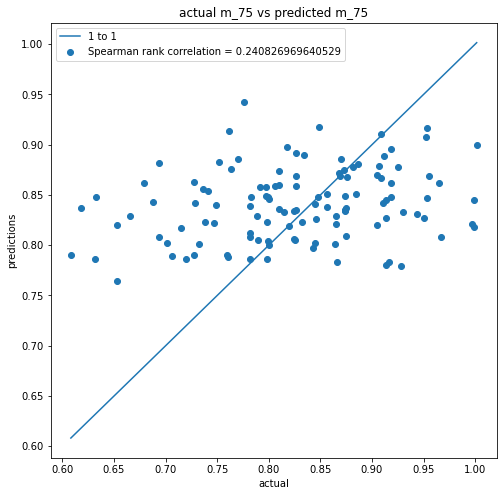

In [22]:
spearman_rank, _ = stats.spearmanr(actuals, predictions)
print("SPEARMAN RANK:",spearman_rank)

fig, ax = plt.subplots(1, figsize=(8,8))
min_mem = min(np.min(actuals), np.min(predictions))
max_mem = max(np.max(actuals), np.max(predictions))
plt.scatter(actuals, predictions, label = f"Spearman rank correlation = {spearman_rank}")
plt.plot([min_mem, max_mem], [min_mem, max_mem], label="1 to 1")
plt.title(f"actual {target} vs predicted {target}")
plt.legend()
plt.ylabel("predictions")
plt.xlabel("actual")
plt.show()

# Saving Predictions


In [23]:
pred_train, actual_train, vid_train = get_predictions(model_type, model, features_train, targets_train, video_ids_train)
pred_valid, actual_valid, vid_valid = get_predictions(model_type, model, features_valid, targets_valid, video_ids_valid)

In [24]:
print("Validation spearman rank:", stats.spearmanr(actual_valid, pred_valid)[0])
print("Training spearman rank:", stats.spearmanr(actual_train, pred_train)[0])

Validation spearman rank: 0.240826969640529
Training spearman rank: 0.9788224035291012


In [37]:
predictions = np.array(pred_train + pred_valid)
actuals = np.array(actual_train + actual_valid)
video_ids = np.array(vid_train + vid_valid)
in_training_set = np.array(np.concatenate([np.ones(len(pred_train)), np.zeros(len(pred_valid))]), dtype=bool)

In [38]:
model_name = "ResNet152_SVR"

In [39]:
model_parameters = {
    "RANDOM_SEED": RANDOM_SEED
}

In [59]:
def save_predictions(model_name, video_ids, actuals, predictions, in_training_set, model_parameters, predictions_dir = PREDICTIONS_DIR):

    if not os.path.exists(predictions_dir):
        os.mkdir(predictions_dir)
        
    model_data_dir = f"{predictions_dir}/model_data.csv"
    if not os.path.exists(model_data_dir):
        model_data = pd.DataFrame(columns=["name", "validation_spearman_rank", "parameters", "predictions", "notes", "is_short_term"])
    else:
        model_data = pd.read_csv(model_data_dir)
        
    model_dir = f"{predictions_dir}/{model_name}"
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        
    pred_filename = f"{model_dir}/{len(os.listdir(model_dir))}.csv"
    
    valid_spearman_rank, _ = stats.spearmanr(actuals[in_training_set], predictions[in_training_set])
    
    pred_data = pd.DataFrame({
        "video_id": vids,
        "prediction": predictions,
        "actual": actuals,
        "in_training_set": in_training_set
    }).sort_values("video_id")
    
    pred_data.to_csv(pred_filename, index = False)
    
    model_info = {
        "name": model_name,
        "validation_spearman_rank": np.around(spearman_rank,4),
        "parameters": model_parameters,
        "predictions": pred_filename,
        "notes": "",
        "is_short_term": False
    }
    
    model_data.append(model_info, ignore_index = True).to_csv(model_data_dir, index = False)
    
    print("Saved model info and predictions: ", model_info)
    

In [60]:
save_predictions(model_name, video_ids, actuals, predictions, in_training_set, model_parameters)

Saved model info and predictions:  {'name': 'ResNet152_SVR', 'validation_spearman_rank': 0.2408, 'parameters': {'RANDOM_SEED': 1}, 'predictions': 'training_set/predictions/ResNet152_SVR/1.csv', 'notes': '', 'is_short_term': False}
